
# **Linear Regression Regularization Lab Notebook**

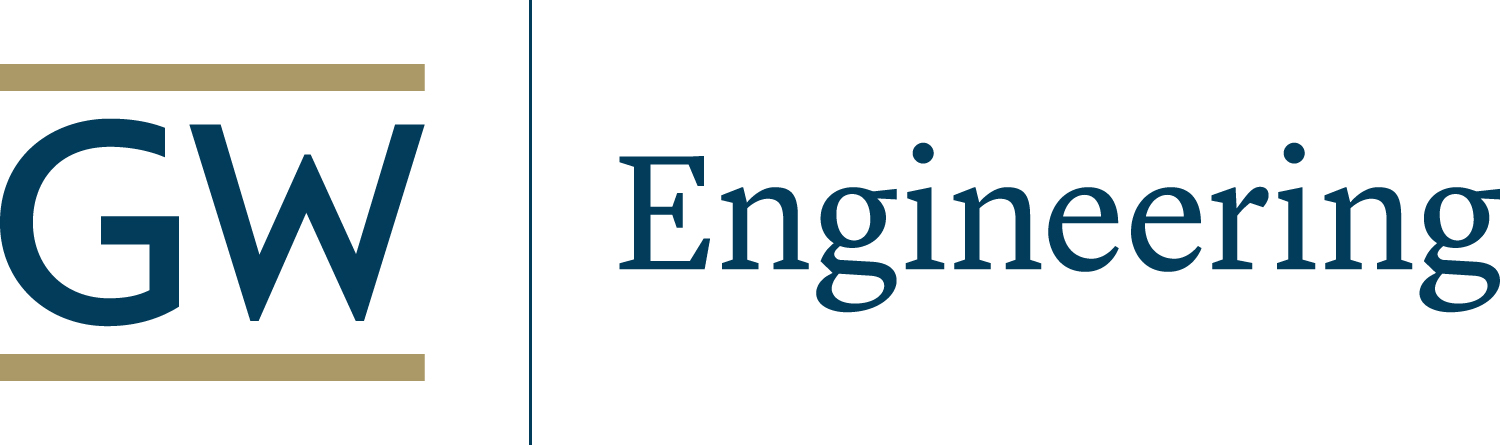


### **Forward Selection Example**

In [2]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.4 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.4 MB/s eta 0:00:00


In [3]:
#Load the libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
#Rememeber to use your Google drive to save work and use data files.
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset (Using Boston dataset as an example)
df_hitters = pd.read_csv('../data/Hitters.csv')


In [5]:
#initial check of the data
df_hitters.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


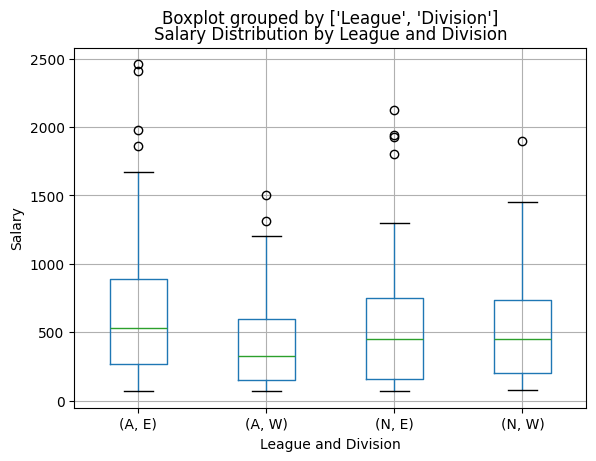

In [6]:
# @title Salary Distribution by League and Division

import matplotlib.pyplot as plt

df_hitters.boxplot(column='Salary', by=['League', 'Division'])
plt.xlabel('League and Division')
plt.ylabel('Salary')
_ = plt.title('Salary Distribution by League and Division')

In [7]:
#do a quick transformation to numeric for the catagorical data
l_encoder = LabelEncoder()

for col in df_hitters.columns:
    if df_hitters[col].dtype == 'object':
        df_hitters[col] = l_encoder.fit_transform(df_hitters[col])

df_hitters.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,0,0,446,33,20,NaN,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1


In [8]:
#dropping NaN but other solutions could be used - impuation.
df_hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [9]:
df_hitters = df_hitters.dropna()

In [10]:
#Predicting Salary
X = df_hitters.drop(['Salary'], axis=1)
y = df_hitters['Salary']

In [11]:
#T-T Split
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=13)

In [12]:
'''
Barebones and selected features regression so we can compare once we use regularication techniques.
There is not a library that does this easily with SM, we we will use sklearn.
'''
model_baseline = LinearRegression()
model_sfs = LinearRegression()

In [19]:
#Lets get the baseline
model_baseline.fit(X_train, y_train)
y_pred = model_baseline.predict(X_test)
y_train_pred = model_baseline.predict(X_train)
#...and get its results
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Train Mean Squared Error:", mse_train)
print("R-squared Train:", r2_train)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Base model coefficients: ", model_baseline.coef_)
print("Base model intercept: ", model_baseline.intercept_)


Train Mean Squared Error: 81554.19720775279
R-squared Train: 0.49612319961816553
Mean Squared Error: 146519.33445108702
R-squared: 0.30600665382448544
Base model coefficients:  [-4.21767291e+00  9.88450921e+00 -9.87027312e+00  1.44762957e+00
  1.04030097e+00  6.33631142e+00 -3.89257397e+01 -8.46961181e-02
  3.36248606e-01  3.81206118e+00  9.33993594e-01  2.94490666e-01
 -1.36178688e+00  2.42298530e+02 -8.36057444e+01  7.14563438e-01
  1.26607149e+00 -1.26253669e+01 -1.65252786e+02]
Base model intercept:  554.560946408656


In [14]:
# Perform forward selection
sfs = SequentialFeatureSelector(model_baseline, n_features_to_select='auto', direction='forward', cv=5)
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[sfs.get_support()]
print("Selected Features:", selected_features)

# Fit the final model with the selected features
model_sfs.fit(X_train[selected_features], y_train)

# Make predictions on the test and train sets
y_pred = model_sfs.predict(X_test[selected_features])
y_train_pred = model_sfs.predict(X_train[selected_features])

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = model_sfs.score(X_train[selected_features], y_train)
mse = mean_squared_error(y_test, y_pred)
r2 = model_sfs.score(X_test[selected_features], y_test)

print("Train Mean Squared Error:", mse_train)
print("R-squared Train:", r2_train)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Selected Features: Index(['Years', 'CHmRun', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts',
       'Assists', 'NewLeague'],
      dtype='object')
Train Mean Squared Error: 109993.15741943763
R-squared Train: 0.32041510894631187
Mean Squared Error: 130197.08382035745
R-squared: 0.3833174973030772


### **Ridge Regression**

In [15]:
#Preferred to scale data for the Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Instantiate the Ridge regression model
ridge = Ridge(alpha=4)  # alpha is the regularization strength

# Fit the model to the training data
ridge.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test_scaled)
y_train_pred = ridge.predict(X_train_scaled)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = ridge.score(X_train_scaled, y_train)
mse = mean_squared_error(y_test, y_pred)
r2 = ridge.score(X_test_scaled, y_test)
print("Train Mean Squared Error:", mse_train)
print("Train R-squared:", r2_train)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Ridge Coefficients:", ridge.coef_)
print("Intercept:", ridge.intercept_)

Train Mean Squared Error: 93182.5462385251
Train R-squared: 0.4242782731280822
Mean Squared Error: 132184.4648627913
R-squared: 0.3739042057062274
Ridge Coefficients: [   0.         -113.4565241    46.49947119  -13.49682916   45.1273489
  -32.81392448   44.62541619  -62.23823086   22.52333688   42.23941545
  120.95821403   16.32191529   79.45255314  -88.01088961   63.23993434
  -58.9907039   119.44989489  121.72074794 -103.33957355  -22.34892441]
Intercept: 457.84860377358495


### **The Lasso**

In [16]:
# Instantiate the Lasso regression model
lasso = Lasso(alpha=4)  # alpha is the regularization strength

# Fit the model to the training data
lasso.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = lasso.predict(X_test_scaled)
y_train_pred = lasso.predict(X_train_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = lasso.score(X_test_scaled, y_test)
print("Train Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("Train R-squared:", lasso.score(X_train_scaled, y_train))
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Ridge Coefficients:", ridge.coef_)
print("Intercept:", ridge.intercept_)

Train Mean Squared Error: 87700.9734219488
Train R-squared: 0.4581457804599297
Mean Squared Error: 130941.77699832268
R-squared: 0.379790235099858
Ridge Coefficients: [   0.         -113.4565241    46.49947119  -13.49682916   45.1273489
  -32.81392448   44.62541619  -62.23823086   22.52333688   42.23941545
  120.95821403   16.32191529   79.45255314  -88.01088961   63.23993434
  -58.9907039   119.44989489  121.72074794 -103.33957355  -22.34892441]
Intercept: 457.84860377358495
